In [1]:
import argparse
from collections import Counter
import configparser
import glob
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import sys

COLORMAP - CM <matplotlib.colors.LinearSegmentedColormap object at 0x2aeac7171f98>
y_
stemg
kellyg
yg
cd
yg_shuf


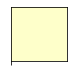

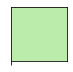

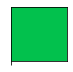

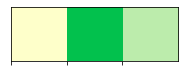

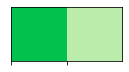

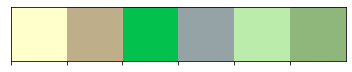

In [2]:
BASE_PATH= "/dors/capra_lab/users/fongsl/enh_ages/landscape/"

configfile_name = os.path.join(BASE_PATH, "config_landscape.ini")
config = configparser.ConfigParser(allow_no_value=True)
config.read(configfile_name)

## get plotting colors, other parameters

sys.path.append(BASE_PATH)
import config_plot as cp

In [8]:
GENOME_BUILD = config["FANTOM"]["GENOME_BUILD"]

FANTOMPATH = config["FANTOM"]["DATA_PATH"]
FANTOM = config["FANTOM"]["DATA_FILE"]

SAMPLE_ID = config["FANTOM"]["SAMPLE_ID"]

OUTPATH = "/dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/no-exon_all_fantom_enh/"
RE = config["FANTOM"]["RESULTS"]

MERGE_DISTANCES = 0

if MERGE_DISTANCES == 0:
    PROMOTERFILE = "promoter_data_hg19.bed"
    PROMOTERSAMPLE_ID = f"all_fantom_pr_merged_{GENOME_BUILD}"
else:
    PROMOTERFILE = f"merged_{MERGE_DISTANCES}_bp_promoters.bed" 
    PROMOTERSAMPLE_ID = f"all_fantom_pr_merged{MERGE_DISTANCES}_{GENOME_BUILD}"

PROMOTER = os.path.join(FANTOMPATH, PROMOTERFILE)

# FUNCTIONS

In [64]:
def getfasta(test_enh, sample_id, test_path, results_path, species):


    cat_fasta = "%s%s.fa" % (results_path, sample_id)
    print(cat_fasta)
    if os.path.exists(cat_fasta) is False:
        os.chdir(test_path)

        chr_cmd = "awk '{print >$1\"_%s_temp.bed\"}' %s" % (sample_id, test_enh) # split test into chrN.bed files
        os.system(chr_cmd)
        print(chr_cmd)

        enh_chr_list = glob.glob("%s/chr*_%s_temp.bed" % (test_path, sample_id)) # glob chromosomes

        for enh_chr in enh_chr_list: # intersect test chrN.bed w/ syntenic block

            chr_num = (enh_chr.split("/")[-1]).split("_")[0]

            dna_path = "/dors/capra_lab/data/dna/human/%s/" % species

            fasta_in = ("%s%s.fa" % (dna_path, chr_num))
            fasta_out = "%s%s_%s.fa" % (results_path, sample_id, chr_num)

            cmd = "bedtools getfasta -fi %s -bed %s -fo %s" %(fasta_in, enh_chr, fasta_out)

            os.system(cmd)

            cleanup_cmd = "rm %s" % enh_chr # clean up chr temp file
            os.system(cleanup_cmd)


        cat_fasta = "%s%s.fa" % (results_path, sample_id)
        cat_cmd = "cat %s%s_chr*.fa > %s" % (results_path, sample_id, cat_fasta)
        os.system(cat_cmd)

        cleanup_cmd = "rm %s%s_chr*.fa" % (results_path, sample_id)
        os.system(cleanup_cmd)

    else:
        print("already done!")

    return cat_fasta


def countgc(sequence):
    gc = []
    total = []
    letters = ["G", "C", "g", "c"]
    counts = Counter(sequence)

    for letter in letters:
        gc.append(int(counts[letter]))

    gc_sum = sum(gc)
    return gc_sum


def format_fa(fasta_file):

    cols = ["seq", "syn_id"]
    df = pd.read_csv(fasta_file, sep = ">",  header =None, names =cols )

    df["syn_id"] = df["syn_id"].shift(1) # need to shift col 1 by 1.
    df = df.dropna() # drop na


    df["GC"] = df["seq"].apply(lambda x: countgc(x)) # get GC content
    df["motif_len"] = df["seq"].apply(lambda x: len(x)) # get sequence len
    longer_than5 = df.loc[df.motif_len>=6].copy()
    longer_than5["GC_density"] = longer_than5["GC"].divide(longer_than5["motif_len"])
    
    # remove x and y chromosomes
    longer_than5 = longer_than5.loc[~longer_than5["syn_id"].str.contains("chrY")]
    longer_than5 = longer_than5.loc[~longer_than5["syn_id"].str.contains("chrX")]

    return longer_than5


def format_syndf(enh_age_file):

    syn_cols = ["chr_syn", "start_syn", "end_syn",
    "enh_id",
    "chr", "start", "end",
    "seg_index", "core_remodeling", "core",
    "mrca",]

    syn = pd.read_csv(FANTOM, sep ='\t', header = None, names = syn_cols)

    syn["syn_id"] = syn.chr_syn + ":" + syn.start_syn.map(str) + "-" + syn.end_syn.map(str)
    syn["enh_len"] = syn.end - syn.start


    # age and taxon file
    syn_gen_bkgd_file = "/dors/capra_lab/projects/enhancer_ages/hg19_syn_gen_bkgd.tsv"
    syn_gen_bkgd= pd.read_csv(syn_gen_bkgd_file, sep = '\t') # read the file
    syn_gen_bkgd[["mrca", "mrca_2"]] = syn_gen_bkgd[["mrca", "mrca_2"]].round(3) # round the ages

    syn_gen_bkgd = syn_gen_bkgd[["mrca", "taxon", "mrca_2", "taxon2"]] # whittle down the df
    syn["mrca"] = syn["mrca"].round(3) # round the ages

    syn = pd.merge(syn, syn_gen_bkgd, how = "left", on = "mrca")

    syn["arch"] = "simple"

    syn.loc[(syn.core_remodeling ==1) & (syn.core ==1), "arch"] = "complex_core"
    syn.loc[(syn.core_remodeling ==1) & (syn.core ==0), "arch"] = "complex_derived"

    return syn


def merge_fa_ages(fa, syn):

    merged = pd.merge(fa, syn, how = "left", on = "syn_id")

    return merged


def make_pdf(file_name, RE):
    outfile = file_name +".pdf"
    outf = os.path.join(RE, outfile)

    return outf


def custom_round(x, base=10):
    return int(base * round(float(x)/base))


def prep_match_len_df(df, id_col, len_col):

    df = df[[id_col, len_col]].drop_duplicates() # get columns

    columns_names = ["matching_ids", "matching_len"]
    df.columns = columns_names # format column names

    return df


def match_len(df1, df2, base_len, balanced_ids_per_bin):

    # round_lengths

    df1.matching_len = df1.matching_len.astype(float).apply(lambda x: custom_round(x, base=base_len)) # round to the nearest 100bp

    df2.matching_len = df2.matching_len.astype(float).apply(lambda x: custom_round(x, base=base_len))

    # set of lengths in both datasets
    lens = set(list(df1.matching_len.unique()) + list(df2.matching_len.unique())) 

    match_dict = {}

    # per length bin
    for length in lens:

        # count the min number ids with that length bin in both datasets
        df2n = len(df2.loc[df2.matching_len == length])
        df1n = len(df1.loc[df1.matching_len == length])

        # choose the number of ids to match on
        # by scaling to the smaller number () of ids.
        min_ids = min(df2n, df1n)

        if length > 0 and min_ids > 0:

            # get ids per length-matched bins
            if balanced_ids_per_bin == 1: # make a balanced set with the same number of ids per bin
                df2_ids = df2.loc[df2.matching_len == length].sample(n = min_ids, replace = False) # sample w/ replacement
                df1_ids = df1.loc[df1.matching_len == length].sample(n = min_ids, replace = False) # sample w/ replacement

            else: # get all ids in length bins

                df2_ids = df2.loc[df2.matching_len == length].sample(n = df2n, replace = False) # sample w/ replacement
                df1_ids = df1.loc[df1.matching_len == length].sample(n = df1n, replace = False) # sample w/ replacement

            balanced = pd.concat([df1_ids, df2_ids])
            match_dict[length] = balanced

    final_matched_id = pd.concat(match_dict.values())

    return final_matched_id.matching_ids.unique()

def compare_gc_arch(df):

    core = df.loc[df.arch == "complex_core", "GC_density"]
    derived = df.loc[df.arch == "complex_derived", "GC_density"]
    simple = df.loc[df.arch == "simple", "GC_density"]

    cstat, cp = stats.mannwhitneyu(core, derived)
    print("core v. derived", cstat, cp )

    stat, p = stats.mannwhitneyu(simple, core)
    print("complex core v simple", stat, p )

    print(df.groupby("arch")["GC_density"].mean(), "mean")

# make fasta files

In [65]:
OUTPATH

'/dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/no-exon_all_fantom_enh/'

In [66]:
enhfasta = getfasta(FANTOM, SAMPLE_ID, FANTOMPATH, OUTPATH, GENOME_BUILD)
prfasta = getfasta(PROMOTER, PROMOTERSAMPLE_ID, FANTOMPATH, OUTPATH, GENOME_BUILD)

/dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/no-exon_all_fantom_enh/all_fanton_enh_hg19.fa
already done!
/dors/capra_lab/projects/enhancer_ages/fantom/data/non-genic/no-exon_all_fantom_enh/all_fantom_pr_merged_hg19.fa
already done!


# format fasta files and calculate GC density

In [74]:
fa = format_fa(enhfasta)
prfa = format_fa(prfasta)

prfa["arch"] = "promoter"
prfa = prfa.loc[prfa.motif_len>=50]  # evaluate only the promoters w/ > 50bp length

syn = format_syndf(FANTOM)

# merge GC content and architecture

In [75]:
df = merge_fa_ages(fa, syn)

## merge enhancer and pr 

In [76]:
df_merged = pd.concat([df, prfa])
df_merged.head()

,seq,syn_id,GC,motif_len,GC_density,chr_syn,start_syn,end_syn,enh_id,chr,...,end,seg_index,core_remodeling,core,mrca,enh_len,taxon,mrca_2,taxon2,arch
0,TGGCCTCTTCTTGGAGGTGACACATTGATAAAGCTGTTTACCCAGC...,chr10:100074404-100074582,85,178,0.477528,chr10,100074404.0,100074582.0,chr10:100074404-100074582,chr10,...,100074582.0,0.0,0.0,1.0,0.175,178.0,Eutheria,0.175,Eutheria (105),simple
1,TGCTCTTCATGCATCGTAGCAGCACAGAAGGCACCAGGACCAGGAA...,chr10:100076038-100076149,59,111,0.531532,chr10,100076038.0,100076149.0,chr10:100076038-100076149,chr10,...,100076149.0,0.0,0.0,1.0,0.380,111.0,Mammalia,0.380,Mammalia (177),simple
2,tgaataaatggtggctattagtgctattattAtctctgtc,chr10:100076500-100076540,13,40,0.325000,chr10,100076500.0,100076540.0,chr10:100076500-100076699,chr10,...,100076699.0,0.0,1.0,1.0,0.380,199.0,Mammalia,0.380,Mammalia (177),complex_core
3,cttgggagttcacagtctggtgaggcacaggcattaaaagaaacag...,chr10:100076540-100076699,72,159,0.452830,chr10,100076540.0,100076699.0,chr10:100076500-100076699,chr10,...,100076699.0,1.0,1.0,0.0,0.175,199.0,Eutheria,0.175,Eutheria (105),complex_derived
4,tgacttttcagctcctcacatgaagaattggagggctttcccccct...,chr10:100082942-100083374,226,432,0.523148,chr10,100082942.0,100083374.0,chr10:100082942-100083374,chr10,...,100083374.0,0.0,0.0,1.0,0.175,432.0,Eutheria,0.175,Eutheria (105),simple


/home/fongsl/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


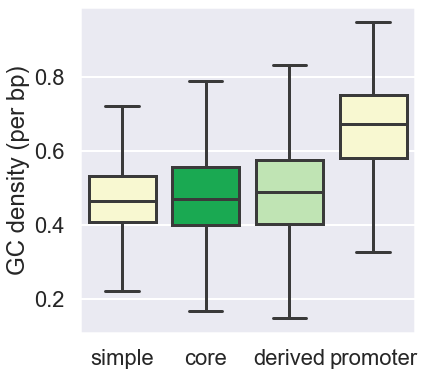

In [82]:
fig, ax = plt.subplots(figsize = (6,6))

hue_order = ["simple", "complex_core", "complex_derived", "promoter"]
x = "arch"
y = "GC_density"
data = df_merged
file_name = "GC_density_all_FANTOM_arch_all_lengths"
outfile = make_pdf(file_name, RE)

sns.set("poster")
xlabs = ["simple", "core", "derived", "promoter"]
sns.boxplot(x, y, data = data, order = hue_order, palette = cp.yg, showfliers = False)
ax.set(#ylim = (0.35, 0.7), 
       xticklabels = xlabs, 
       ylabel = "GC density (per bp)",
      xlabel = "")
plt.savefig(outfile, bbox_inches = 'tight')

In [80]:
df_merged.groupby("arch")["GC_density"].describe()

,count,mean,std,min,25%,50%,75%,max
arch,,,,,,,,
complex_core,11489.0,0.478428,0.122448,0.000000,0.398649,0.470320,0.555147,1.000000
complex_derived,15357.0,0.481683,0.143254,0.000000,0.402174,0.487179,0.574468,1.000000
promoter,13781.0,0.657404,0.120400,0.196078,0.580000,0.671875,0.750000,0.948276
simple,20087.0,0.468811,0.106288,0.000000,0.407602,0.465116,0.532740,1.000000


In [79]:
core_gc = df_merged.loc[df_merged.arch == "complex_core", 'GC_density']
der_gc = df_merged.loc[df_merged.arch == "complex_derived", 'GC_density']
stats.mannwhitneyu(core_gc, der_gc)

MannwhitneyuResult(statistic=83846613.5, pvalue=1.7227499959935264e-12)

# evaluate length distribution

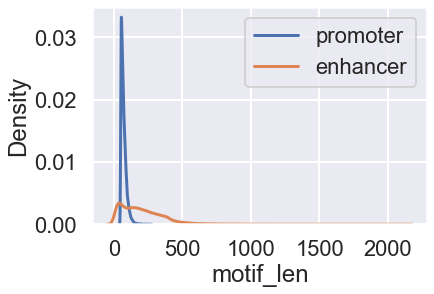

In [70]:
fig, ax =plt.subplots()
sns.kdeplot(prfa.motif_len, label = "promoter")


sns.kdeplot(fa.motif_len, label = "enhancer")
ax.legend()

In [31]:
#%% select only the records that match lengths

enh_to_match = prep_match_len_df(df, "enh_id", "enh_len")


pr_to_match = prep_match_len_df(prfa, "syn_id", "motif_len")

In [60]:
fa.head()

,seq,syn_id,GC,motif_len,GC_density
1,TGGCCTCTTCTTGGAGGTGACACATTGATAAAGCTGTTTACCCAGC...,chr10:100074404-100074582,85,178,0.477528
3,TGCTCTTCATGCATCGTAGCAGCACAGAAGGCACCAGGACCAGGAA...,chr10:100076038-100076149,59,111,0.531532
5,tgaataaatggtggctattagtgctattattAtctctgtc,chr10:100076500-100076540,13,40,0.325000
7,cttgggagttcacagtctggtgaggcacaggcattaaaagaaacag...,chr10:100076540-100076699,72,159,0.452830
9,tgacttttcagctcctcacatgaagaattggagggctttcccccct...,chr10:100082942-100083374,226,432,0.523148


# match promoter lengths to enhancer lengths

In [32]:
base_len = 10
balanced_ids_per_bin = 1
matching_len_ids = match_len(enh_to_match, pr_to_match, base_len, balanced_ids_per_bin)

len(matching_len_ids) #29780 matching IDs

4110

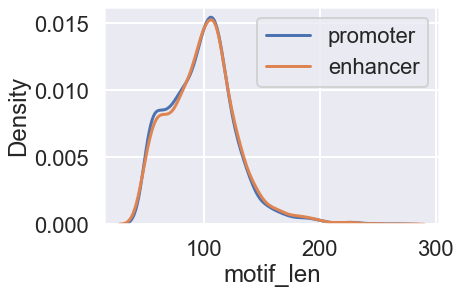

In [33]:
#%% plot matching lengths

match_prfa = prfa.loc[prfa["syn_id"].isin(matching_len_ids)]

match_enh = df.loc[df["enh_id"].isin(matching_len_ids)]

fig, ax =plt.subplots()
sns.kdeplot(match_prfa["motif_len"], label = "promoter")
sns.kdeplot(match_enh["enh_len"], label = "enhancer")
ax.legend()

In [58]:
len(match_enh.enh_id.unique())

2055

## concat length matched elements 

In [34]:
all_matched = pd.concat([match_enh, match_prfa])

all_matched.describe()

,GC,motif_len,GC_density,start_syn,end_syn,start,end,seg_index,core_remodeling,core,mrca,enh_len,mrca_2
count,4443.000000,4443.000000,4443.000000,2.388000e+03,2.388000e+03,2.388000e+03,2.388000e+03,2388.000000,2388.000000,2388.000000,2388.000000,2388.00000,2388.000000
mean,52.342786,90.811389,0.564147,7.696859e+07,7.696868e+07,7.696859e+07,7.696869e+07,0.167923,0.264657,0.867253,0.235429,99.11474,0.241831
std,25.450568,34.375099,0.163217,5.852788e+07,5.852789e+07,5.852789e+07,5.852789e+07,0.425252,0.441243,0.339372,0.182662,29.94436,0.177038
min,0.000000,6.000000,0.000000,1.130760e+05,1.131910e+05,1.130760e+05,1.131910e+05,0.000000,0.000000,0.000000,0.000000,46.00000,0.000000
25%,34.000000,67.000000,0.452468,3.252289e+07,3.252299e+07,3.252289e+07,3.252299e+07,0.000000,0.000000,1.000000,0.175000,78.00000,0.175000
50%,51.000000,94.000000,0.567010,6.338589e+07,6.338594e+07,6.338587e+07,6.338596e+07,0.000000,0.000000,1.000000,0.175000,99.00000,0.175000
75%,69.000000,112.000000,0.692308,1.148210e+08,1.148211e+08,1.148210e+08,1.148211e+08,0.000000,1.000000,1.000000,0.308000,115.00000,0.308000
max,183.000000,271.000000,0.935484,2.475114e+08,2.475114e+08,2.475114e+08,2.475114e+08,3.000000,1.000000,1.000000,0.957000,271.00000,0.957000


## plot summary of GC content

/home/fongsl/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


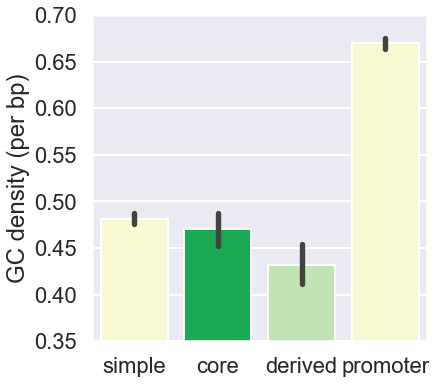

In [54]:
fig, ax = plt.subplots(figsize = (6,6))

hue_order = ["simple", "complex_core", "complex_derived", "promoter"]
x = "arch"
y = "GC_density"
data = all_matched
file_name = "GC_density_all_FANTOM_arch"
outfile = make_pdf(file_name, RE)

sns.set("poster")
xlabs = ["simple", "core", "derived", "promoter"]
sns.barplot(x, y, data = data, order = hue_order, palette = cp.yg)
ax.set(ylim = (0.35, 0.7), 
       xticklabels = xlabs, 
       ylabel = "GC density (per bp)",
      xlabel = "")
plt.savefig(outfile, bbox_inches = 'tight')

In [56]:
core_gc = all_matched.loc[all_matched.arch == "complex_core", 'GC_density']
der_gc = all_matched.loc[all_matched.arch == "complex_derived", 'GC_density']
stats.mannwhitneyu(core_gc, der_gc)

MannwhitneyuResult(statistic=46781.5, pvalue=0.08525245332252229)

In [49]:
#%% all enhancers

compare_gc_arch(df)

compare_gc_arch(match_enh)

#%%

core v. derived 83846613.5 1.7227499959935264e-12
complex core v simple 112300502.5 3.6811149310893494e-05
arch
complex_core       0.478428
complex_derived    0.481683
simple             0.468811
Name: GC_density, dtype: float64 mean
core v. derived 46781.5 0.08525245332252229
complex core v simple 259811.5 0.043194922397324025
arch
complex_core       0.470420
complex_derived    0.431429
simple             0.481529
Name: GC_density, dtype: float64 mean


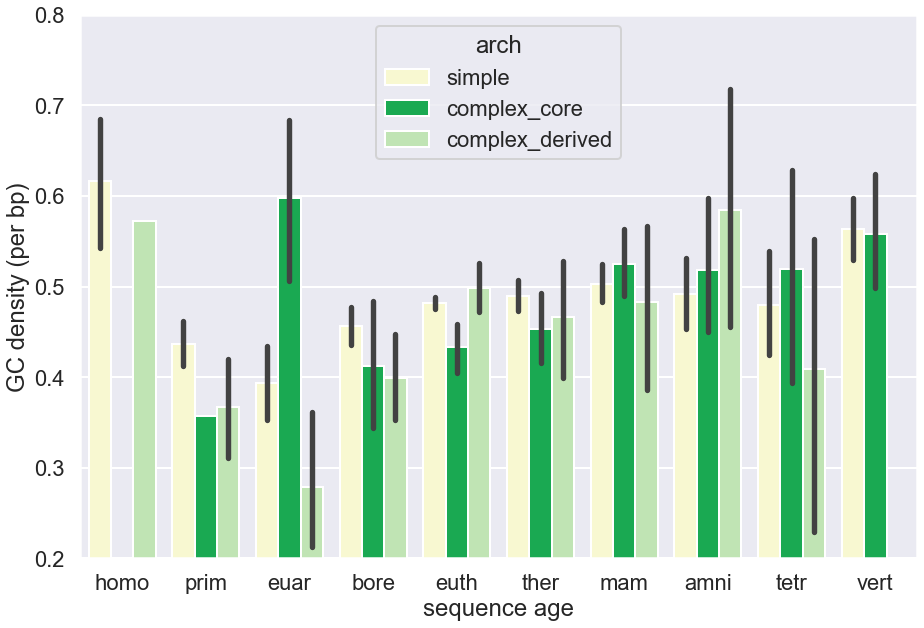

In [51]:
fig, ax = plt.subplots(figsize = (15,10))

x = "mrca_2"
y = "GC_density"
data = all_matched
hue = "arch"
hue_order = ["simple", "complex_core", "complex_derived"]
file_name = "GC_density_all_FANTOM_arch_mrca"
outfile = make_pdf(file_name, RE)

xlab = ["homo", "prim", "euar", "bore", "euth", "ther", "mam", "amni", "tetr", "vert" ]
sns.barplot(x, y, data = data, hue = hue, hue_order = hue_order, palette = cp.yg)
ax.set(ylim = (0.2, 0.8), 
      xlabel = "sequence age", 
      ylabel = "GC density (per bp)", 
      xticklabels = xlab)
plt.savefig(outfile, bbox_inches = 'tight')

/home/fongsl/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,GC,motif_len,GC_density
count,14213.000000,14213.000000,14213.000000
mean,46.461057,70.368184,0.656548
std,16.490118,19.839211,0.120184
min,10.000000,50.000000,0.196078
25%,35.000000,56.000000,0.578947
50%,43.000000,65.000000,0.671053
75%,54.000000,79.000000,0.747126
max,183.000000,266.000000,0.948276


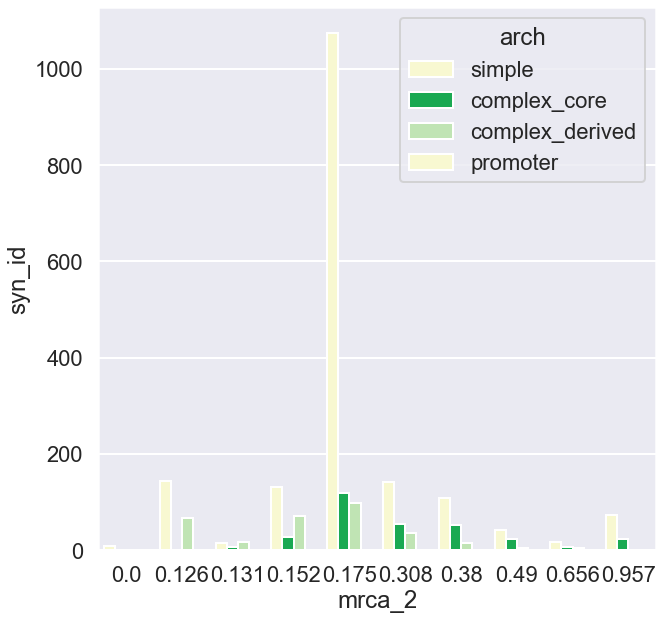

In [47]:
#%%

count_agearch = all_matched.groupby(["arch", "mrca_2"])["syn_id"].count().reset_index()

fig, ax = plt.subplots(figsize = (10,10))
x = "mrca_2"
y = "syn_id"
hue = "arch"
data = count_agearch
file_name = "count_all_FANTOM_arch"
outfile = make_pdf(file_name, RE)

sns.barplot(x, y, data = count_agearch, hue = hue, hue_order = hue_order, palette = cp.yg)
plt.savefig(outfile, bbox_inches = 'tight')
#%%

prfa.describe()